In [2]:
import sys
import os

# 프로젝트의 루트 경로를 추가 (lib 디렉토리 상위 폴더 기준)
project_root = "D:/MotionBERT"  # 실제 경로로 변경
sys.path.append(project_root)

# 경로가 잘 추가되었는지 확인
print(sys.path)


['c:\\Users\\zesky\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip', 'c:\\Users\\zesky\\AppData\\Local\\Programs\\Python\\Python39\\DLLs', 'c:\\Users\\zesky\\AppData\\Local\\Programs\\Python\\Python39\\lib', 'c:\\Users\\zesky\\AppData\\Local\\Programs\\Python\\Python39', '', 'C:\\Users\\zesky\\AppData\\Roaming\\Python\\Python39\\site-packages', 'c:\\Users\\zesky\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages', 'd:\\alphapose', 'c:\\Users\\zesky\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\timm-0.1.20-py3.9.egg', 'c:\\Users\\zesky\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\munkres-1.1.4-py3.9.egg', 'c:\\Users\\zesky\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32', 'c:\\Users\\zesky\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32\\lib', 'c:\\Users\\zesky\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\Pythonwin', 'D:/MotionBERT']


In [3]:
import os
import os.path as osp
import numpy as np
import argparse
import pickle
from tqdm import tqdm
import time
import random
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from lib.utils.tools import *
from lib.utils.learning import *
from lib.utils.utils_data import flip_data
from lib.utils.utils_mesh import flip_thetas_batch
from lib.data.dataset_wild import WildDetDataset
# from lib.model.loss import *
from lib.model.model_mesh import MeshRegressor
from lib.utils.vismo import render_and_save, motion2video_mesh
from lib.utils.utils_smpl import *
from scipy.optimize import least_squares
from tqdm.notebook import tqdm

# 경로 설정
project_root = "D:/MotionBERT"
sys.path.append(project_root)

# 설정 클래스
class Config:
    config = "D:/MotionBERT/configs/mesh/MB_ft_pw3d.yaml"
    evaluate = "D:/MotionBERT/checkpoint/mesh/FT_MB_release_MB_ft_pw3d/best_epoch.bin"
    data_root = "D:/MotionBERT/data/mesh"
    json_path = "D:/alphapose-results.json"
    vid_path = "D:/boxing1.mp4"
    out_path = "D:/output"
    ref_3d_motion_path = None
    pixel = False
    focus = None
    clip_len = 243

opts = Config()


In [4]:

# 3D 모션 정규화 함수
def err(p, x, y):
    return np.linalg.norm(p[0] * x + np.array([p[1], p[2], p[3]]) - y, axis=-1).mean()

def solve_scale(x, y):
    print('Estimating camera transformation.')
    best_res = 100000
    best_scale = None
    for init_scale in tqdm(range(0, 2000, 5)):
        p0 = [init_scale, 0.0, 0.0, 0.0]
        est = least_squares(err, p0, args=(x.reshape(-1, 3), y.reshape(-1, 3)))
        if est['fun'] < best_res:
            best_res = est['fun']
            best_scale = est['x'][0]
    print('Pose matching error = %.2f mm.' % best_res)
    return best_scale

# Configuration 로드
args = get_config(opts.config)

smpl = SMPL("D:/MotionBERT/data/mesh", batch_size=1)
J_regressor = smpl.J_regressor_h36m

# 모델 초기화
start_time = time.time()
model_backbone = load_backbone(args)
print(f'Init backbone time: {(time.time() - start_time):.2f}s')

start_time = time.time()
model = MeshRegressor(args, backbone=model_backbone, dim_rep=args.dim_rep, hidden_dim=args.hidden_dim, dropout_ratio=args.dropout)
print(f'Init whole model time: {(time.time() - start_time):.2f}s')

# if torch.cuda.is_available():
#     model = nn.DataParallel(model)
#     model = model.cuda()


# Checkpoint 로드
chk_filename = opts.evaluate
print('Loading checkpoint:', chk_filename)
checkpoint = torch.load(chk_filename, map_location=lambda storage, loc: storage)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint['model'].items()}
model.load_state_dict(state_dict)
model.eval()


Init backbone time: 0.44s
Init whole model time: 0.16s
Loading checkpoint: D:/MotionBERT/checkpoint/mesh/FT_MB_release_MB_ft_pw3d/best_epoch.bin


MeshRegressor(
  (backbone): DSTformer(
    (joints_embed): Linear(in_features=3, out_features=512, bias=True)
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks_st): ModuleList(
      (0-4): 5 x Block(
        (norm1_s): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (norm1_t): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (attn_s): Attention(
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=512, out_features=512, bias=True)
          (qkv): Linear(in_features=512, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (attn_t): Attention(
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=512, out_features=512, bias=True)
          (qkv): Linear(in_features=512, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2_s): LayerNorm((512,), e

In [5]:
checkpoint['model']

OrderedDict([('module.backbone.temp_embed',
              tensor([[[[ 0.0004, -0.0819,  0.1359,  ...,  0.1120,  0.0748,  0.1509]],
              
                       [[ 0.0151,  0.0181,  0.0871,  ...,  0.1394,  0.0686,  0.0436]],
              
                       [[ 0.0728, -0.0287, -0.0116,  ...,  0.0944,  0.0593, -0.0060]],
              
                       ...,
              
                       [[-0.0445, -0.0269,  0.0590,  ..., -0.0752,  0.0613,  0.0219]],
              
                       [[-0.0076, -0.0014,  0.0573,  ...,  0.0537, -0.0353, -0.0074]],
              
                       [[ 0.0284, -0.0807,  0.1334,  ...,  0.0850, -0.0394,  0.0815]]]])),
             ('module.backbone.pos_embed',
              tensor([[[-0.0075,  0.0064,  0.0992,  ...,  0.0075,  0.0125, -0.0060],
                       [ 0.0092,  0.0042, -0.0289,  ...,  0.0139,  0.0616, -0.0142],
                       [-0.0035,  0.0558,  0.0263,  ...,  0.0175,  0.0356, -0.0041],
              

In [6]:
state_dict

{'backbone.temp_embed': tensor([[[[ 0.0004, -0.0819,  0.1359,  ...,  0.1120,  0.0748,  0.1509]],
 
          [[ 0.0151,  0.0181,  0.0871,  ...,  0.1394,  0.0686,  0.0436]],
 
          [[ 0.0728, -0.0287, -0.0116,  ...,  0.0944,  0.0593, -0.0060]],
 
          ...,
 
          [[-0.0445, -0.0269,  0.0590,  ..., -0.0752,  0.0613,  0.0219]],
 
          [[-0.0076, -0.0014,  0.0573,  ...,  0.0537, -0.0353, -0.0074]],
 
          [[ 0.0284, -0.0807,  0.1334,  ...,  0.0850, -0.0394,  0.0815]]]]),
 'backbone.pos_embed': tensor([[[-0.0075,  0.0064,  0.0992,  ...,  0.0075,  0.0125, -0.0060],
          [ 0.0092,  0.0042, -0.0289,  ...,  0.0139,  0.0616, -0.0142],
          [-0.0035,  0.0558,  0.0263,  ...,  0.0175,  0.0356, -0.0041],
          ...,
          [ 0.0048, -0.0223,  0.0495,  ...,  0.0094,  0.0508, -0.0260],
          [ 0.0367, -0.0477,  0.0394,  ...,  0.0134,  0.0292, -0.0116],
          [ 0.0683,  0.0002,  0.0178,  ...,  0.0176, -0.0734, -0.0096]]]),
 'backbone.joints_embed.weight'

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 493/493 [06:43<00:00,  1.22it/s]


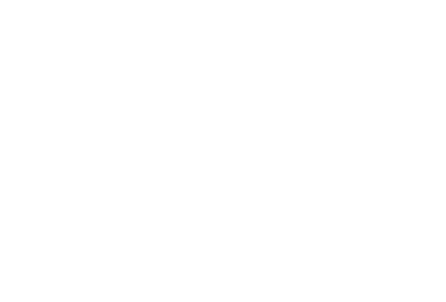

In [7]:

# 데이터 로더 설정
testloader_params = {
    'batch_size': 1,
    'shuffle': False,
    'num_workers': 0,  # Jupyter에서는 0으로 설정 필요
    'pin_memory': True,
    'drop_last': False
}

# 비디오 및 데이터셋 로드
vid = imageio.get_reader(opts.vid_path, 'ffmpeg')
fps_in = vid.get_meta_data()['fps']
vid_size = vid.get_meta_data()['size']
os.makedirs(opts.out_path, exist_ok=True)

if opts.pixel:
    # Pixel 좌표계 유지
    wild_dataset = WildDetDataset(opts.json_path, clip_len=opts.clip_len, vid_size=vid_size, scale_range=None, focus=opts.focus)
else:
    # 좌표계 [-1,1] 스케일링
    wild_dataset = WildDetDataset(opts.json_path, clip_len=opts.clip_len, scale_range=[1, 1], focus=opts.focus)

test_loader = DataLoader(wild_dataset, **testloader_params)

# 모델 추론 및 결과 저장
verts_all = []
reg3d_all = []
with torch.no_grad():
    for batch_input in tqdm(test_loader):
        batch_size, clip_frames = batch_input.shape[:2]
        output = model(batch_input.float())
        batch_input_flip = flip_data(batch_input)
        output_flip = model(batch_input_flip)
        output_flip_pose = output_flip[0]['theta'][:, :, :72]
        output_flip_shape = output_flip[0]['theta'][:, :, 72:]
        output_flip_pose = flip_thetas_batch(output_flip_pose).reshape(-1, 72)
        output_flip_shape = output_flip_shape.reshape(-1, 10)
        output_flip_smpl = smpl(
            betas=output_flip_shape,
            body_pose=output_flip_pose[:, 3:],
            global_orient=output_flip_pose[:, :3],
            pose2rot=True
        )
        output_flip_verts = output_flip_smpl.vertices.detach()
        J_regressor_batch = J_regressor[None, :].expand(output_flip_verts.shape[0], -1, -1).to(output_flip_verts.device)
        output_flip_kp3d = torch.matmul(J_regressor_batch, output_flip_verts)
        output_flip_back = [{
            'verts': output_flip_verts.reshape(batch_size, clip_frames, -1, 3) * 1000.0,
            'kp_3d': output_flip_kp3d.reshape(batch_size, clip_frames, -1, 3),
        }]
        output_final = [{}]
        for k, v in output_flip_back[0].items():
            output_final[0][k] = (output[0][k] + output_flip_back[0][k]) / 2.0
        output = output_final
        verts_all.append(output[0]['verts'].cpu().numpy())
        reg3d_all.append(output[0]['kp_3d'].cpu().numpy())

verts_all = np.concatenate(np.hstack(verts_all))
reg3d_all = np.concatenate(np.hstack(reg3d_all))

if opts.ref_3d_motion_path:
    ref_pose = np.load(opts.ref_3d_motion_path)
    x = ref_pose - ref_pose[:, :1]
    y = reg3d_all - reg3d_all[:, :1]
    scale = solve_scale(x, y)
    root_cam = ref_pose[:, :1] * scale
    verts_all = verts_all - reg3d_all[:, :1] + root_cam

render_and_save(verts_all, osp.join(opts.out_path, 'mesh.mp4'), keep_imgs=False, fps=fps_in, draw_face=True)


In [8]:
verts_all

array([[[  -2.134705 , -860.5794   , -168.0062   ],
        [  -9.384286 , -845.8728   , -168.98096  ],
        [   3.8140192, -842.947    , -165.42517  ],
        ...,
        [ -65.37697  , -822.42633  ,  -30.13334  ],
        [ -66.379074 , -823.8208   ,  -31.705086 ],
        [ -69.70327  , -821.3073   ,  -32.52034  ]],

       [[  52.33837  , -863.6721   , -219.8865   ],
        [  48.85012  , -848.80493  , -224.96835  ],
        [  57.12961  , -847.1948   , -213.44357  ],
        ...,
        [ -82.65408  , -816.91235  , -153.57489  ],
        [ -82.529015 , -818.28326  , -155.38058  ],
        [ -84.31926  , -815.4425   , -158.03491  ]],

       [[-211.3056   , -782.0239   , -280.05493  ],
        [-214.83835  , -767.5012   , -273.9994   ],
        [-200.96837  , -767.0248   , -277.93945  ],
        ...,
        [-192.50612  , -781.0294   , -121.6281   ],
        [-194.26309  , -782.002    , -122.69086  ],
        [-196.98462  , -779.0067   , -121.20316  ]],

       ...,

      

In [9]:
verts_all.shape

(493, 6890, 3)

In [46]:
reg3d_all.shape

(493, 17, 3)

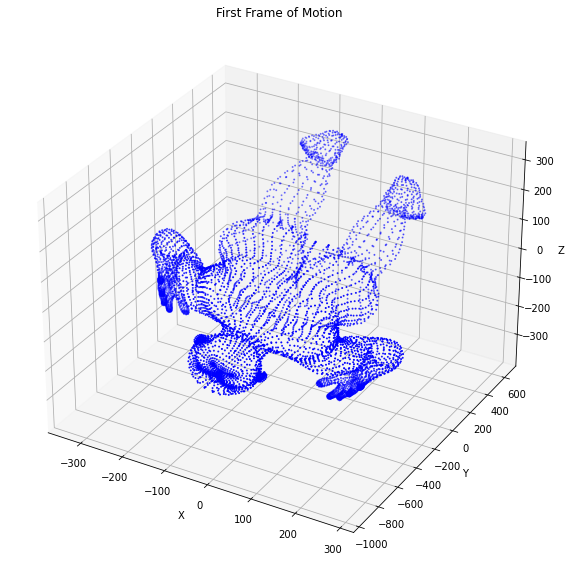

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 첫 번째 프레임 추출
first_frame = verts_all[0]  # (6890, 3) 형태

# 3D 플롯을 생성합니다.
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# x, y, z 좌표 추출
x = first_frame[:, 0]
y = first_frame[:, 1]
z = first_frame[:, 2]

# 3D 스캐터 플롯으로 시각화
ax.scatter(x, y, z, s=1, c='b', marker='o')

# 축 라벨과 제목을 설정합니다.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('First Frame of Motion')

# 화면에 플롯을 출력합니다.
plt.show()


In [49]:
import plotly.graph_objects as go

# 첫 번째 프레임 추출
first_frame = verts_all[0]  # (6890, 3) 형태

# x, y, z 좌표 추출
x = first_frame[:, 0]
y = first_frame[:, 1]
z = first_frame[:, 2]

# 3D 스캐터 플롯 생성
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color='blue',  # 마커 색상
        opacity=0.8
    )
)])

# 레이아웃 설정
fig.update_layout(
    title='First Frame of Motion',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

# 플롯 출력
fig.show()



In [64]:
import plotly.graph_objects as go

# 첫 번째 프레임 추출
first_frame = reg3d_all[0]  # (6890, 3) 형태

# x, y, z 좌표 추출
x = first_frame[:, 0]
y = first_frame[:, 1]
z = first_frame[:, 2]

# 3D 스캐터 플롯 생성
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color='blue',  # 마커 색상
        opacity=0.8
    )
)])

# 레이아웃 설정
fig.update_layout(
    title='First Frame of Motion',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

# 플롯 출력
fig.show()


In [65]:
import numpy as np

def align_scales_and_positions(verts_all, reg3d_all):
    """
    reg3d_all의 크기와 위치를 verts_all에 맞추는 함수.

    Parameters:
    - verts_all: (N, 3) 또는 (N, M, 3)의 3D 메쉬 데이터.
    - reg3d_all: (N, K, 3)의 키포인트 데이터.

    Returns:
    - aligned_reg3d: verts_all의 크기와 위치에 맞춘 reg3d_all.
    """
    # 1. verts_all의 범위 및 중심 계산
    verts_min = verts_all.min(axis=(0, 1)) if verts_all.ndim == 3 else verts_all.min(axis=0)
    verts_max = verts_all.max(axis=(0, 1)) if verts_all.ndim == 3 else verts_all.max(axis=0)
    verts_center = (verts_max + verts_min) / 2
    verts_scale = verts_max - verts_min

    # 2. reg3d_all의 범위 및 중심 계산
    reg_min = reg3d_all.min(axis=(0, 1))
    reg_max = reg3d_all.max(axis=(0, 1))
    reg_center = (reg_max + reg_min) / 2
    reg_scale = reg_max - reg_min

    # 3. 스케일 조정 (reg3d_all을 verts_all에 맞춤)
    scale_ratio = verts_scale / reg_scale
    scaled_reg3d = (reg3d_all - reg_center) * scale_ratio + verts_center

    return scaled_reg3d

# 사용 예제
aligned_reg3d = align_scales_and_positions(verts_all, reg3d_all)


In [66]:
import plotly.graph_objects as go

# 첫 번째 프레임 추출
first_frame = aligned_reg3d[0]  # (6890, 3) 형태

# x, y, z 좌표 추출
x = first_frame[:, 0]
y = first_frame[:, 1]
z = first_frame[:, 2]

# 3D 스캐터 플롯 생성
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color='blue',  # 마커 색상
        opacity=0.8
    )
)])

# 레이아웃 설정
fig.update_layout(
    title='First Frame of Motion',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

# 플롯 출력
fig.show()


In [68]:
import plotly.graph_objects as go

def plot_aligned_and_verts(verts_all, aligned_reg3d):
    # 첫 번째 프레임 추출
    first_frame = verts_all[0]  # (6890, 3)
    aligned_reg3d_frame = aligned_reg3d[0]  # (493, 17, 3)

    # verts_all의 x, y, z 좌표 추출
    x_verts = first_frame[:, 0]
    y_verts = first_frame[:, 1]
    z_verts = first_frame[:, 2]

    # aligned_reg3d의 x, y, z 좌표 추출
    x_reg = aligned_reg3d_frame[:, 0]
    y_reg = aligned_reg3d_frame[:, 1]
    z_reg = aligned_reg3d_frame[:, 2]

    # 3D 스캐터 플롯 생성 (verts_all)
    fig = go.Figure(data=[go.Scatter3d(
        x=x_verts,
        y=y_verts,
        z=z_verts,
        mode='markers',
        marker=dict(
            size=2,
            color='blue',  # verts_all 색상
            opacity=0.8
        ),
        name='verts_all'
    )])

    # 3D 스캐터 플롯 생성 (aligned_reg3d)
    fig.add_trace(go.Scatter3d(
        x=x_reg,
        y=y_reg,
        z=z_reg,
        mode='markers',
        marker=dict(
            size=4,
            color='red',  # aligned_reg3d 색상
            opacity=0.8
        ),
        name='aligned_reg3d'
    ))

    # 레이아웃 설정
    fig.update_layout(
        title='Verts and Aligned Reg3D Visualization',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=1200,  # 플롯 너비
        height=800   # 플롯 높이
    )

    # 플롯 출력
    fig.show()

# 사용 예제
plot_aligned_and_verts(verts_all, aligned_reg3d)
